# Capstone Project for Applied Data Science Course

This is the jupyter notebook for capstone project for applied data science course. In this project, we attempt to understand if the restauruant business in Bangalore is saturated and if not, to identify the market opportunities. We also attempt to identify the location where the market opportunity has higher chance of being successful and the possible target customers for the identified market opportunity and location

Import the required libraries 

In [42]:
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import json

from sklearn.cluster import KMeans

In [43]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



Configure foursquare credentials to access information using their APIs

In [44]:
CLIENT_ID = '5VKRRYN1VIQP34JT0MDOGC4Q5F40F0RRMTVKZC5KSI5WTLC3'
CLIENT_SECRET = 'Q1LEB4OJBMK30ZAQVHIL5CUU3F35DJ5R2AON2ZC0UOZBIODI' 
VERSION = '20190605' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: 5VKRRYN1VIQP34JT0MDOGC4Q5F40F0RRMTVKZC5KSI5WTLC3
CLIENT_SECRET:Q1LEB4OJBMK30ZAQVHIL5CUU3F35DJ5R2AON2ZC0UOZBIODI


Check that access to information through foursquare APIs are successful by getting information 
on top level categories for venues and their IDs. 

In [45]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)

category_list=requests.get(url).json()["response"]['categories']

category_id = {}
print("Top level categories:")
for item in category_list:
    category_id[item['name']] = item['id']
 
category_id

Top level categories:


{'Arts & Entertainment': '4d4b7104d754a06370d81259',
 'College & University': '4d4b7105d754a06372d81259',
 'Event': '4d4b7105d754a06373d81259',
 'Food': '4d4b7105d754a06374d81259',
 'Nightlife Spot': '4d4b7105d754a06376d81259',
 'Outdoors & Recreation': '4d4b7105d754a06377d81259',
 'Professional & Other Places': '4d4b7105d754a06375d81259',
 'Residence': '4e67e38e036454776db1fb3a',
 'Shop & Service': '4d4b7105d754a06378d81259',
 'Travel & Transport': '4d4b7105d754a06379d81259'}

Find the location co-ordinates for the city of Bangalore (also, known as Bengaluru)

In [46]:
address = 'Bengaluru, IN'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
loc_latitude = location.latitude
loc_longitude = location.longitude

print('The geograpical coordinate of Bangalore are {}, {}.'.format(loc_latitude, loc_longitude))

The geograpical coordinate of Bangalore are 13.10901775, 77.6019002736083.


Given the location for Bangalore, use foursquare APIs to find details of venues that falls under the food category within a radius of 50 km. Collect the information in a dataframe, venue. For each venue, we maintain details on venue ID, name, co-ordinates and the sub category for the venue. 

In [47]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                                                    CLIENT_ID, CLIENT_SECRET, VERSION, loc_latitude, loc_longitude, 50000, 500, category_id['Food'])

# url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
#                                                      CLIENT_ID, CLIENT_SECRET, VERSION, loc_latitude, loc_longitude, 100000, 500, category_id['Food'])

query_venues_response=requests.get(url).json()["response"];

results = query_venues_response['groups'][0]['items']
# results=query_venues_response['venues']

venues_list=[]
for item in results:
    venues_list.append((item['venue']['id'], item['venue']['name'], item['venue']['location']['lat'], item['venue']['location']['lng'], item['venue']['categories'][0]['name']))
    # venues_list.append((item['id'], item['name'], item['location']['lat'], item['location']['lng'], item['categories'][0]['name']))
                                                            
venues = pd.DataFrame([item for item in venues_list])
venues.columns = ['Venue ID', 'Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
print("No of results returned:", len(venues_list))
print("No of categories of venues for location:", len(venues['Venue Category'].unique()))

venues_grouped=venues.groupby('Venue Category').nunique().sort_values('Venue ID', ascending=False)
print("Maximum number of resturants found for {} with the number of restaurants being {}".format(venues_grouped.index[0], venues_grouped.iloc[0]['Venue ID']))

No of results returned: 100
No of categories of venues for location: 35
Maximum number of resturants found for Indian Restaurant with the number of restaurants being 16


Plot the venues in terms of number of restaurants per sub category

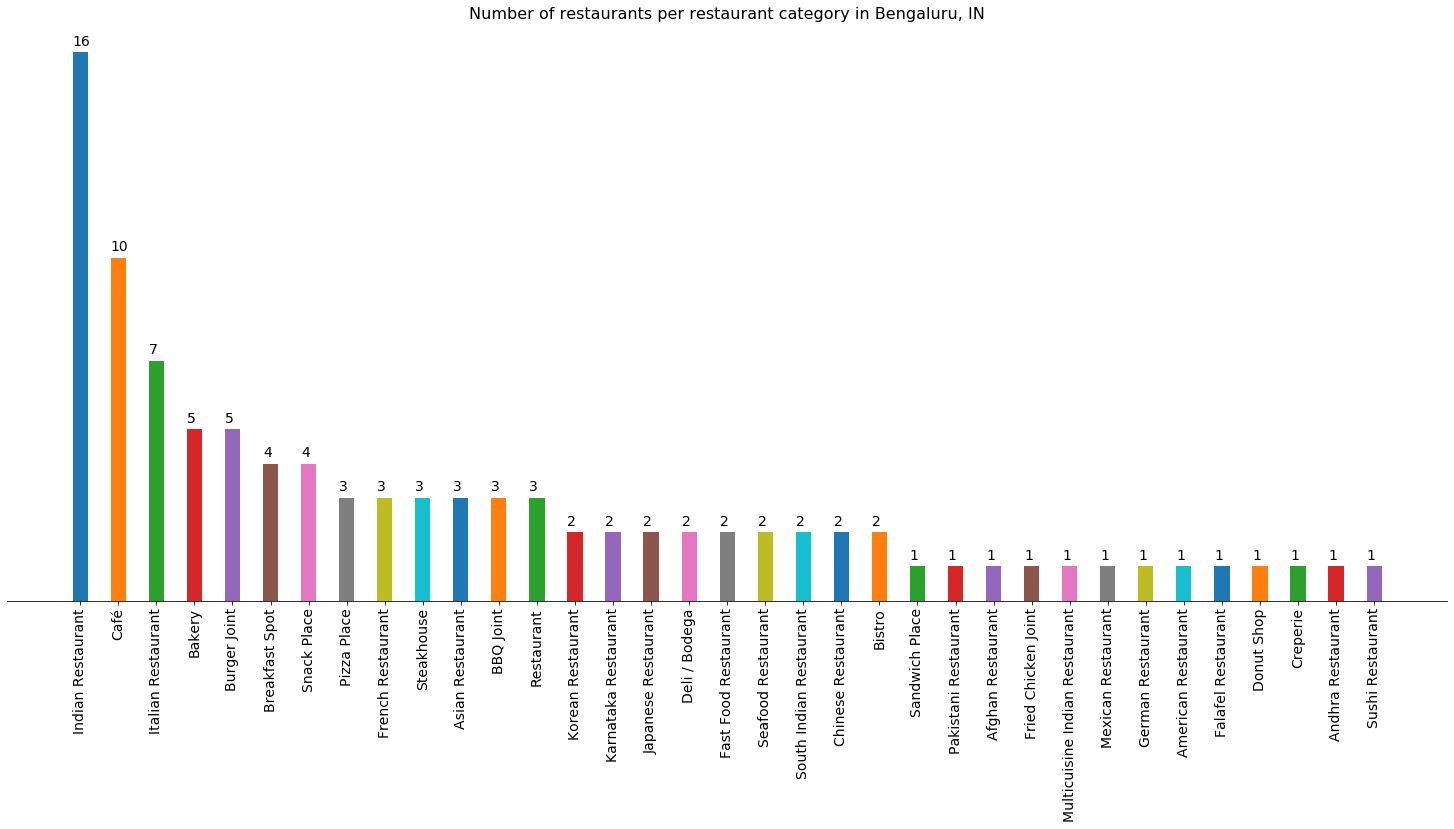

In [48]:
fig=plt.figure(figsize=(20,8))
ax = fig.add_axes([0, 0, 1, 1])

barsize=0.8
bar_pos=[2 * i for i in range(venues_grouped.shape[0])]
bar_data=venues_grouped['Venue ID'].to_list()
bar_label=venues_grouped.index.to_list()

for i in range(len(bar_pos)):
  plt.bar(bar_pos[i], bar_data[i], width=barsize, label=bar_label[i])  
  plt.annotate(bar_data[i], xy=(bar_pos[i] - 0.4, bar_data[i] + 0.2), fontsize=14)  


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])


plt.xticks([(2*d)  for d in range(len(bar_label))], bar_label, rotation='vertical', fontsize=14)

plt.title('Number of restaurants per restaurant category in {}'.format(address), fontsize=16)
#plt.legend(fontsize=14)

plt.show()

We find that the number of cafe's, and the resturants that serve indian and italian food are quite high compared to others. Similarly, there are quite a good number of bakeries, burger joints and breakfast or snack place

We now, take the restaurant category that has the high number of occurrence and plot it in the map to see if any particular category is concentrated to a locality in Bangalore. We denote each high occurrence category with different color and visualize on the map if they are evenly spread across Bangalore

In [49]:
color=['white'] * (len(venues_grouped)-1)
color[0:6]=['green', 'blue', 'purple', 'orange', 'red', 'black', 'violet']
venues_grouped['Color']=color
# venues_grouped

In [50]:
map_bengaluru = folium.Map(location=[loc_latitude, loc_longitude], zoom_start=12)

# add markers to map
for index,(lat, lng, label, category) in enumerate(zip(venues['Venue Latitude'], venues['Venue Longitude'], venues['Venue Name'], venues['Venue Category'])):
    label = folium.Popup(label, parse_html=True)
    category_count=venues_grouped.at[category, 'Venue ID']
    if category_count > 3:
        venue_color=venues_grouped.at[category,'Color'];
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=venue_color,
            fill=True,
            fill_color=venue_color,
            fill_opacity=0.7,
            parse_html=False).add_to(map_bengaluru)  
    
map_bengaluru


With the available samples we could see that each high occurrence restaurant category has moderate spread - We could at the least reasonably conclude that no particular restaurant category has concentration in a specific locality. It seems Bangalore is truly a cosmopolitan city

Now, for each venue, we get the number of likes for the venue. Also, for each venue we get the user who has given the like and based on that information we build the users who liked each venue category

In [53]:
user_likes=[]
like_count=[]

for index, row in venues.iterrows():
   
    # https://api.foursquare.com/v2/venues/VENUE_ID/likes
    url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(row['Venue ID'], CLIENT_ID, CLIENT_SECRET, VERSION)  
    response=requests.get(url).json()["response"];

    # print("No of likes for venue ", row['Venue ID'], ":", response['likes']['count'])
    like_count.append(response['likes']['count'])
        
    for user in response['likes']['items']:
        # print(user['id'])
        user_likes.append([user['id'],row['Venue Category']])
    
venues['Like Count'] = like_count

Now get the number of restaurants per category for the venues. Similarly get the number of likes per category for the venues. Merge both the data into a single data frame, which now holds the number of restaurants and the number of likes per category

In [55]:
venues.head()

venues_count=venues.loc[:,['Venue ID','Venue Category']]
venues_count_sum=venues_count.groupby('Venue Category').nunique().rename(columns={'Venue ID' : 'Venue Count', 'Venue Category':'Dummy'}).drop(columns=['Dummy'])

venues_like_count=venues.loc[:,['Venue ID', 'Venue Category', 'Like Count']]
venues_like_count_sum=venues_like_count.groupby('Venue Category').sum()

venues_count=pd.merge(venues_count_sum, venues_like_count_sum, left_index=True, right_index=True).sort_values('Venue Count', ascending=False)
# venues_count

As the number of likes for a venue category outweighs the number of restaurants in that category, by an order of magnitude, it will be good to normalize the venue count and the like count for the category. For both features, we normalize linearly using (x(i) - min) / (max - min), with min as zero. We plot the resulting normalized data to visualize the number of likes vs the number of available restaurant per category

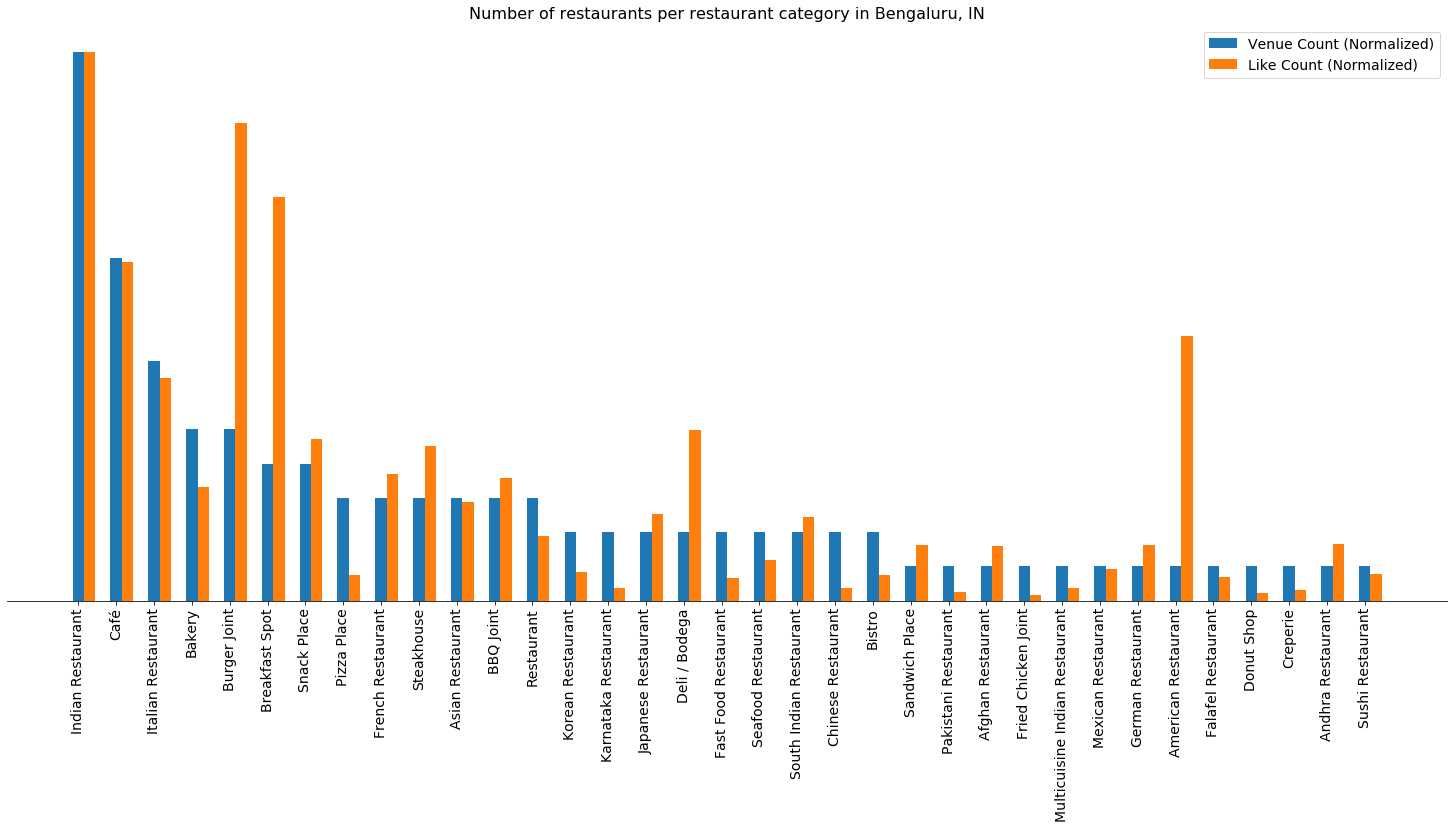

In [59]:
fig=plt.figure(figsize=(20,8))
ax = fig.add_axes([0, 0, 1, 1])

barsize=0.6

bar_pos_0=[2 * i for i in range(venues_grouped.shape[0])]
bar_pos_1=[barsize+i for i in bar_pos_0]
bar_pos=[bar_pos_0, bar_pos_1]

bar_data_0=venues_count['Venue Count'].to_list()
max_data_0=max(bar_data_0)
min_data_0=min(bar_data_0)
bar_data_0_norm=[(i / max_data_0) for i in bar_data_0]


bar_data_1=venues_count['Like Count'].to_list()
max_data_1=max(bar_data_1)
min_data_1=min(bar_data_1)
bar_data_1_norm=[(i / max_data_1) for i in bar_data_1]


bar_data=[bar_data_0_norm, bar_data_1_norm]

legend_label=['Venue Count (Normalized)', 'Like Count (Normalized)']

for i in range(len(bar_pos)):
  plt.bar(bar_pos[i], bar_data[i], width=barsize, label=legend_label[i])  

  # for j in range(len(bar_pos[i])):
     # label=round(bar_data[i][j],2)
     # plt.annotate(label, xy=(((j*2)-0.35)+(i*barsize), label + 0.1), fontsize=14) 
    

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

bar_label=venues_count.index.to_list()
plt.xticks([(2*d)  for d in range(len(bar_label))], bar_label, rotation='vertical', fontsize=14)

plt.title('Number of restaurants per restaurant category in {}'.format(address), fontsize=16)
plt.legend(fontsize=14)

plt.show()

From the plot, we could easily spot the market opportunity in restaurant categories such as american restaurant, burger joint or breakfast spots. The normalized count of number of likes for such categories heavily outweighs the number of restaurants available for that category

Get the geoJSON file describing the municipal division of Bangalore localities. For each municipal division, get the location co-ordinates

In [61]:
!wget --quiet https://raw.githubusercontent.com/datameet/Municipal_Spatial_Data/master/Bangalore/BBMP.GeoJSON -O bangalore_municipality.json
print('GeoJSON file downloaded!')
bangalore_geo = r'bangalore_municipality.json'

GeoJSON file downloaded!


In [62]:
geo_request = requests.get('https://raw.githubusercontent.com/datameet/Municipal_Spatial_Data/master/Bangalore/BBMP.GeoJSON')
response=geo_request.json()

ward_list=[]
for i in range(198):
    # print(i,":", response['features'][i]['properties']['WARD_NAME'],"(",response['features'][i]['properties']['LAT'], ",", response['features'][i]['properties']['LON'], ")")
     ward_list.append([response['features'][i]['properties']['WARD_NAME'],response['features'][i]['properties']['LAT'], response['features'][i]['properties']['LON']])
    
ward_dataframe=pd.DataFrame(ward_list)
ward_dataframe.columns=['Name','Latitude','Longitude']
# ward_dataframe

For the identified market opportunity of high demand restaurant categories, get the category id from foursquare. Create an ID string to use in foursquare API

In [64]:
demand_category_id={'Burger Joint': '4bf58dd8d48988d16c941735', 
                    'American Restaurant': '4bf58dd8d48988d14e941735'}                    
category_str=''
for key in demand_category_id.keys():
    if len(category_str): 
        category_str = category_str + "," + demand_category_id[key]
    else:
        category_str = demand_category_id[key]
    
category_str

'4bf58dd8d48988d16c941735,4bf58dd8d48988d14e941735'

For each municipal division, query foursquare to find the number of venues of high demand category in that municipal division 

In [65]:
demand_category_count=[]
for index, row in ward_dataframe.iterrows():
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}&intent={}'.format(
                                                     CLIENT_ID, CLIENT_SECRET, VERSION, row['Latitude'], row['Longitude'], 1000, 100, category_str,'browse')
    
    query_venues_response=requests.get(url).json()["response"];
    # print(query_venues_response)
    
    if 'venues' in query_venues_response: 
        count = len(query_venues_response['venues'])
    else:
        count = 0
        
    # for venue in query_venues_response['venues']:
        # print(venue['id'],":",venue['name'],",",venue['categories'][0]['name'])
    
    demand_category_count.append(count)

ward_dataframe['Venue Count'] = demand_category_count
# ward_dataframe

Visualize the number of venues of high demand category in each municipal division using choropleth map. The map gives an idea of where the high demand category restaurants are located in Bangalore

In [66]:
bangalore_cmap = folium.Map(location=[loc_latitude, loc_longitude], zoom_start=12)
bangalore_cmap
bangalore_cmap.choropleth(
    geo_data=bangalore_geo,
    data=ward_dataframe,
    columns=['Name', 'Venue Count'],
    key_on='feature.properties.WARD_NAME',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Food Categories Count of Interest'
)

# display map
bangalore_cmap

We have earlier got information on users who has liked specific category of restaurants. From that data, we create a one hot map of restaurant category and mark the number of likes, a specific user has made for each category

In [67]:
user_likes_df=pd.DataFrame(user_likes)
user_likes_df.transpose()
user_likes_df.columns=['User ID', 'Venue Category']
# print(user_likes_df.shape)

user_likes_onehot = pd.get_dummies(user_likes_df[['Venue Category']], prefix="", prefix_sep="")
user_likes_onehot['User ID'] = user_likes_df['User ID'] 
fixed_columns = [user_likes_onehot.columns[-1]] + list(user_likes_onehot.columns[:-1])
user_likes_onehot = user_likes_onehot[fixed_columns]
# print(user_likes_onehot.shape)

user_likes_onehot_grouped = user_likes_onehot.groupby('User ID').mean().reset_index()
# print(user_likes_onehot_grouped.shape)

Now user K-Means to cluster the user group

In [76]:
kclusters = 4
user_likes_grouped_clustering = user_likes_onehot_grouped.drop('User ID', 1)
print(user_likes_grouped_clustering.shape)
print("")

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(user_likes_grouped_clustering)
# print(kmeans.labels_)
# print("")

# user_likes_onehot_grouped.insert(0,'Cluster',kmeans.labels_) 
# print(kmeans.labels_.shape)
print(user_likes_onehot_grouped.shape)
print("")

# user_likes_onehot_grouped

(224, 36)

(224, 37)



For each cluster of users, get the categories liked by  users in that cluster

In [77]:
unique,count=np.unique(kmeans.labels_, return_counts=True)
# print(np.asarray((unique,count)).T)
# print("")

likes_cluster=user_likes_onehot_grouped.drop(['User ID'],axis=1)
for cluster in range(kclusters):
    print("Cluser category", cluster)
    likes_cluster_grouped=likes_cluster.loc[likes_cluster['Cluster']==cluster].drop(['Cluster'],axis=1)
    likes_cluster_grouped_frame=likes_cluster_grouped.sum(axis=0).to_frame()
    likes_cluster_grouped_frame=likes_cluster_grouped_frame.sort_values(by=0, ascending=False).reset_index()
    likes_cluster_grouped_frame.columns=['Category','Count']
    # print(likes_cluster_grouped_frame)

    for index, row in likes_cluster_grouped_frame.iterrows():
        if row['Count'] != 0:
            print(row['Category'], row['Count'])
    
    print("")

Cluser category 0
Restaurant 9.0
Bakery 8.666666666666668
Snack Place 8.666666666666668
Burger Joint 8.5
BBQ Joint 7.0
Pizza Place 6.5
Steakhouse 6.5
French Restaurant 6.333333333333333
Asian Restaurant 6.083333333333333
Chinese Restaurant 6.0
Deli / Bodega 5.25
Fast Food Restaurant 5.0
South Indian Restaurant 4.583333333333333
Karnataka Restaurant 4.5
Japanese Restaurant 4.25
Korean Restaurant 3.333333333333333
Multicuisine Indian Restaurant 3.0
German Restaurant 3.0
Afghan Restaurant 3.0
Seafood Restaurant 2.75
Bistro 2.75
Mexican Restaurant 2.5
Sandwich Place 2.25
American Restaurant 2.0
Creperie 2.0
Falafel Restaurant 2.0
Donut Shop 1.8333333333333333
Andhra Restaurant 1.8333333333333333
Pakistani Restaurant 1.5
Fried Chicken Joint 1.3333333333333333
Indian Restaurant 1.25
Sushi Restaurant 0.75
Breakfast Spot 0.5
Italian Restaurant 0.3333333333333333
Café 0.25

Cluser category 1
Café 23.0
Steakhouse 1.0
Asian Restaurant 0.5
Snack Place 0.5

Cluser category 2
Breakfast Spot 7.5
Pizz